<b>Target :</b> 
```1. Design a basic network with any parameters ```

```2. Reduce the parameteres <= target parameters```

In [8]:
!pip install torchsummary
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [9]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [10]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [11]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

def model_summary():
  model = Net().to(device)
  summary(model, input_size=(1, 28, 28))

cuda


In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [14]:
def plot_result():
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

In [15]:
class Net(nn.Module):

    def conv_block (self, in_channels, out_channels, kernel_size, padding = 1) :
      return nn.Sequential(
            nn.Conv2d (in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding, bias = False),
            nn.ReLU())
        
    def out_block(self, in_channels, kernel_size = 1):
      return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=10, kernel_size = kernel_size, padding = 0, bias = False))


    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = self.conv_block(1, 32, 3)
        self.conv2 = self.conv_block(32, 32, 3, 0)
        self.conv3 = self.conv_block(32, 32, 3)
        self.conv4 = self.conv_block(32, 32, 3, 0)
        self.conv5 = self.conv_block(32, 32, 3)
        self.conv6 = self.conv_block(32, 32, 3, 0)
        self.conv7 = self.out_block(32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

model_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 26, 26]           9,216
              ReLU-4           [-1, 32, 26, 26]               0
         MaxPool2d-5           [-1, 32, 13, 13]               0
            Conv2d-6           [-1, 32, 13, 13]           9,216
              ReLU-7           [-1, 32, 13, 13]               0
            Conv2d-8           [-1, 32, 11, 11]           9,216
              ReLU-9           [-1, 32, 11, 11]               0
        MaxPool2d-10             [-1, 32, 5, 5]               0
           Conv2d-11             [-1, 32, 5, 5]           9,216
             ReLU-12             [-1, 32, 5, 5]               0
           Conv2d-13             [-1, 32, 3, 3]           9,216
             ReLU-14             [-1, 3

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.13373522460460663 Batch_id=468 Accuracy=73.78: 100%|██████████| 469/469 [00:11<00:00, 40.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1146, Accuracy: 9623/10000 (96.23%)

EPOCH: 1


Loss=0.23487581312656403 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:11<00:00, 40.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0565, Accuracy: 9825/10000 (98.25%)

EPOCH: 2


Loss=0.08921872824430466 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:11<00:00, 40.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0600, Accuracy: 9802/10000 (98.02%)

EPOCH: 3


Loss=0.024807395413517952 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:11<00:00, 42.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9860/10000 (98.60%)

EPOCH: 4


Loss=0.008298767730593681 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:11<00:00, 41.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9879/10000 (98.79%)

EPOCH: 5


Loss=0.01699884794652462 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:11<00:00, 41.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9873/10000 (98.73%)

EPOCH: 6


Loss=0.047340113669633865 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:11<00:00, 40.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9885/10000 (98.85%)

EPOCH: 7


Loss=0.037268415093421936 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:11<00:00, 41.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9885/10000 (98.85%)

EPOCH: 8


Loss=0.00978067796677351 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:11<00:00, 40.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9891/10000 (98.91%)

EPOCH: 9


Loss=0.014581348747015 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:11<00:00, 40.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9876/10000 (98.76%)

EPOCH: 10


Loss=0.031410057097673416 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:11<00:00, 40.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9899/10000 (98.99%)

EPOCH: 11


Loss=8.422045357292518e-05 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:11<00:00, 40.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9893/10000 (98.93%)

EPOCH: 12


Loss=0.005058798938989639 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:11<00:00, 41.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9903/10000 (99.03%)

EPOCH: 13


Loss=0.000932771188672632 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:11<00:00, 40.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9907/10000 (99.07%)

EPOCH: 14


Loss=0.01354131381958723 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:11<00:00, 41.35it/s]



Test set: Average loss: 0.0278, Accuracy: 9916/10000 (99.16%)



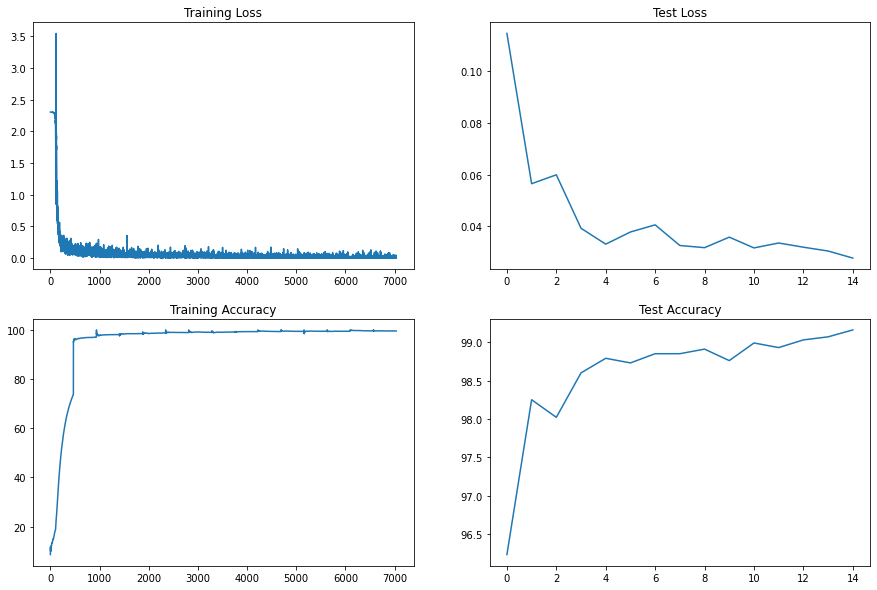

In [16]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

plot_result()

## Results:

<b>Parameters:</b> 49,248

<b>Best Train Accuracy:</b> 99.61

<b>Best Test Accuracy:</b> 99.16

<b>Analysis:</b>
The model parameters exceeds the required target and based on the training and test result we can see that the network is overfitting but still we can acheive the required target, let us try to reduce the parameters to the maximum

In [19]:
class Net(nn.Module):

    def conv_block (self, in_channels, out_channels, kernel_size, padding = 1) :
      return nn.Sequential(
            nn.Conv2d (in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding, bias = False),
            nn.ReLU())
        
    def out_block(self, in_channels, kernel_size = 1):
      return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=10, kernel_size = kernel_size, padding = 0, bias = False))


    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = self.conv_block(1, 10, 3)
      self.conv2 = self.conv_block(10, 10, 3, 0)
      self.conv3 = self.conv_block(10, 11, 3)
      self.conv4 = self.conv_block(11, 11, 3, 0)
      self.conv5 = self.conv_block(11, 12, 3)
      self.conv6 = self.conv_block(12, 12, 3, 0)
      self.conv7 = self.out_block(12, 3)
      self.pool = nn.MaxPool2d(2, 2)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

model_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
            Conv2d-3           [-1, 10, 26, 26]             900
              ReLU-4           [-1, 10, 26, 26]               0
         MaxPool2d-5           [-1, 10, 13, 13]               0
            Conv2d-6           [-1, 11, 13, 13]             990
              ReLU-7           [-1, 11, 13, 13]               0
            Conv2d-8           [-1, 11, 11, 11]           1,089
              ReLU-9           [-1, 11, 11, 11]               0
        MaxPool2d-10             [-1, 11, 5, 5]               0
           Conv2d-11             [-1, 12, 5, 5]           1,188
             ReLU-12             [-1, 12, 5, 5]               0
           Conv2d-13             [-1, 12, 3, 3]           1,296
             ReLU-14             [-1, 1

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.21004505455493927 Batch_id=468 Accuracy=36.01: 100%|██████████| 469/469 [00:11<00:00, 41.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2218, Accuracy: 9286/10000 (92.86%)

EPOCH: 1


Loss=0.17312538623809814 Batch_id=468 Accuracy=95.36: 100%|██████████| 469/469 [00:11<00:00, 41.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1048, Accuracy: 9661/10000 (96.61%)

EPOCH: 2


Loss=0.07650766521692276 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:11<00:00, 42.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0703, Accuracy: 9780/10000 (97.80%)

EPOCH: 3


Loss=0.20839668810367584 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:10<00:00, 42.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9828/10000 (98.28%)

EPOCH: 4


Loss=0.08329158276319504 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:11<00:00, 42.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0538, Accuracy: 9834/10000 (98.34%)

EPOCH: 5


Loss=0.009046931751072407 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:11<00:00, 42.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9869/10000 (98.69%)

EPOCH: 6


Loss=0.01054075825959444 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:10<00:00, 44.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9837/10000 (98.37%)

EPOCH: 7


Loss=0.020036237314343452 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:10<00:00, 43.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9872/10000 (98.72%)

EPOCH: 8


Loss=0.011549937538802624 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:10<00:00, 42.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9875/10000 (98.75%)

EPOCH: 9


Loss=0.04238183796405792 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:10<00:00, 43.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9881/10000 (98.81%)

EPOCH: 10


Loss=0.02397274225950241 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:11<00:00, 42.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9874/10000 (98.74%)

EPOCH: 11


Loss=0.10879430919885635 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:10<00:00, 43.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9883/10000 (98.83%)

EPOCH: 12


Loss=0.007805926725268364 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:10<00:00, 42.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9889/10000 (98.89%)

EPOCH: 13


Loss=0.03128267452120781 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:10<00:00, 42.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9897/10000 (98.97%)

EPOCH: 14


Loss=0.025175271555781364 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:10<00:00, 43.12it/s]



Test set: Average loss: 0.0403, Accuracy: 9877/10000 (98.77%)



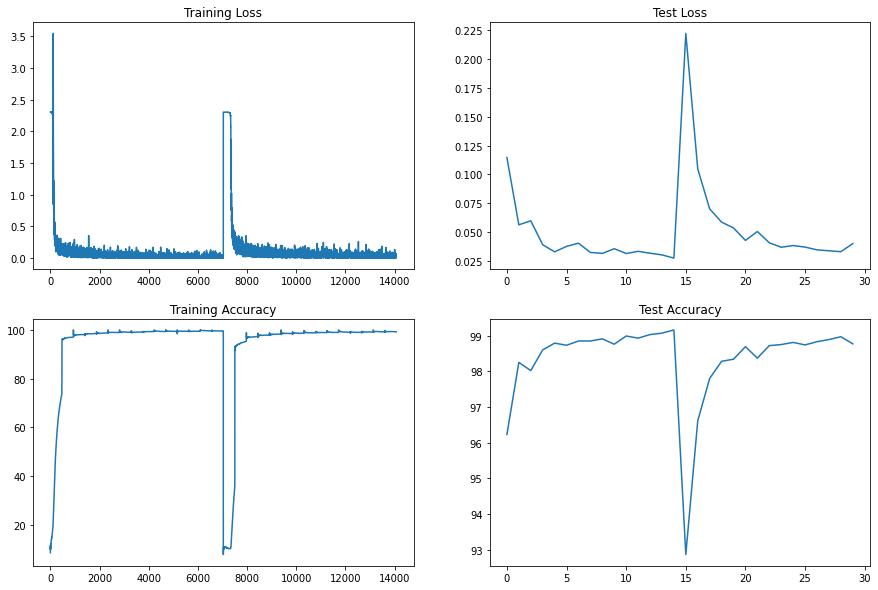

In [20]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

plot_result()

## Results:

<b>Parameters:</b> 6,633

<b>Best Train Accuracy:</b> 99.24

<b>Best Test Accuracy:</b> 98.97

<b>Analysis:</b>
After multiple regression, 7,668 parametersgave us traininig accuracy of 99.24 and test accuracy of 98.94 and based on the result we decided to use 6,633 as our target parameters